In [ ]:
import torch

# Confirm that the GPU is detected

assert torch.cuda.is_available()

# Get the GPU device name.
device_name = torch.cuda.get_device_name()
n_gpu = torch.cuda.device_count()
print(f"Found device: {device_name}, n_gpu: {n_gpu}")
device = torch.device("cuda")

Found device: Tesla T4, n_gpu: 1


In [ ]:
!pip install transformers
!pip install -U -q PyDrive

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 55.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 118.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from transformers import XLMRobertaForSequenceClassification, AdamW, XLMRobertaConfig
from torch.utils.data import TensorDataset, random_split
from transformers import AutoTokenizer
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import sys
import numpy as np
import time
import datetime

def tokenize_and_format(sentences):
  tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased", do_lower_case=False)

  # Tokenize all of the sentences and map the tokens to thier word IDs.
  input_ids = []
  attention_masks = []

  # For every sentence...
  for sentence in sentences:
      # `encode_plus` will:
      #   (1) Tokenize the sentence.
      #   (2) Prepend the `[CLS]` token to the start.
      #   (3) Append the `[SEP]` token to the end.
      #   (4) Map tokens to their IDs.
      #   (5) Pad or truncate the sentence to `max_length`
      #   (6) Create attention masks for [PAD] tokens.
      encoded_dict = tokenizer.encode_plus(
                          sentence,                      # Sentence to encode.
                          add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                          max_length = 64,           # Pad & truncate all sentences.
                          pad_to_max_length = True,
                          truncation = True,
                          return_attention_mask = True,   # Construct attn. masks.
                          return_tensors = 'pt',     # Return pytorch tensors.
                    )

      # Add the encoded sentence to the list.
      input_ids.append(encoded_dict['input_ids'])

      # And its attention mask (simply differentiates padding from non-padding).
      attention_masks.append(encoded_dict['attention_mask'])
  return input_ids, attention_masks

def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


The cell below imports some helper functions we wrote to demonstrate the task on the sample tweet dataset.

In [ ]:
import pandas as pd

data = pd.read_csv("/content/NLP Ethos - ethos.csv")
data = data.sample(frac = 1).reset_index(drop=True)
total = data.shape[0]
train_data = data.iloc[:801, 2:]
train_data = train_data.sample(frac = 1).reset_index(drop=True)
validation_data_eng = data.iloc[801:944, 2:]
validation_data_eng = validation_data_eng.sample(frac = 1).reset_index(drop=True)
validation_data_hindi = data.iloc[944:, 2:]
validation_data_hindi = validation_data_hindi.sample(frac = 1).reset_index(drop=True)
train_data.head()

,Label,Translation
0,1,I love deaf people. I can scream on them and I...
1,0,यह फकहैड मुझे यहूदी होने पर शर्मिंदा करता है। ...
2,1,"On todays episode of ""Guess That Gender"""
3,1,"ये लोग जानवर हैं, वे कभी नहीं सुधरेंगे। हमारी ..."
4,0,My best friend is muslim. And he is the best m...


In [ ]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
validation_data_eng.head()

,Label,Translation
0,1,I wish HIV to your butthole male whore
1,1,अच्छा किया स्लोवाकिया और भगवान आशीर्वाद दे। मस...
2,1,He shoulda shot every single one of them.ï»¿
3,0,मुझे बहुत कुछ पसंद आया जो तुमने यहां कहा। मुझे...
4,0,IM GAY AND FUCKING PROUD FUCK BITCHES LIKE THE...


In [ ]:
validation_data_hindi.head()

,Label,Translation
0,1,Those deaf people are like rats in dark places...
1,1,In America there are about ten million homogay...
2,0,इस बात पर निर्भर करता है कि क्या रायन रेनोल्ड्...
3,1,"हर बार जब मैं उसे हिजाब, नकाब या बुर्का या गंद..."
4,1,आश्चर्य है कि बेल्जियम में बुर्के पर प्रतिबंध ...


In [ ]:
print('Shape of training data is:', train_data.shape)
print('Shape of validation data (eng) is:', validation_data_eng.shape)
print('Shape of validation data (hindi) is:', validation_data_hindi.shape)

train_len = train_data.shape[0]
val_len_eng = validation_data_eng.shape[0]
val_len_hindi = validation_data_hindi.shape[0]

Shape of training data is: (801, 2)
Shape of validation data (eng) is: (143, 2)
Shape of validation data (hindi) is: (78, 2)


<Axes: xlabel='Label', ylabel='count'>

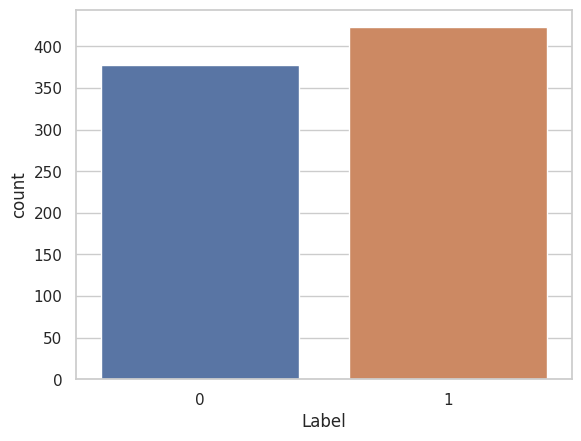

In [ ]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=train_data['Label'])

<Axes: xlabel='Label', ylabel='count'>

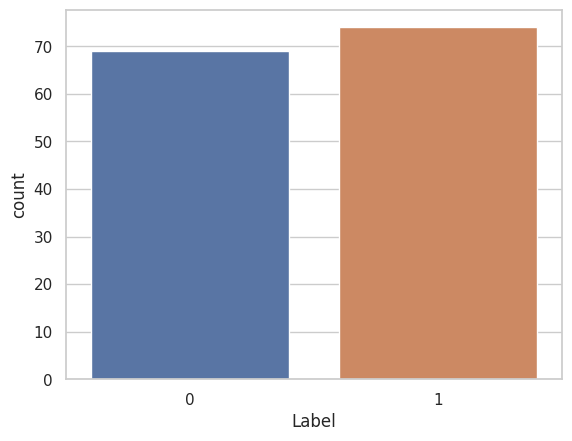

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data_eng['Label'])

<Axes: xlabel='Label', ylabel='count'>

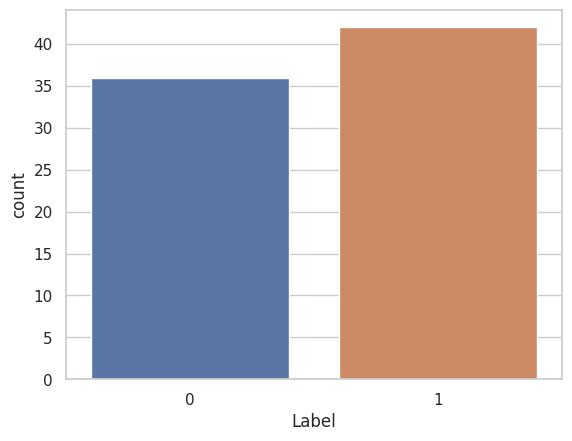

In [ ]:
sns.set_theme(style="whitegrid")
sns.countplot(x=validation_data_hindi['Label'])

In [ ]:
text = data.Translation.values
labels = data.Label.values

### tokenize_and_format() is a helper function provided in helpers.py ###
input_ids, attention_masks = tokenize_and_format(text)

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', text[0])
print('Token IDs:', input_ids[0])

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  हर महिला द्विपक्षीय नौकरी: कम कौशल; न्यूनतम शैक्षणिक योग्यता आवश्यक; ज्यादा शारीरिक थकान नहीं होती; अंदर का काम; समय सीमित होता है।
Token IDs: tensor([   101,  85465,  50353,    882,  27155, 106872,  32662,  21571,    884,
         78530,  19444,  10914,    131,  30730,    865,  78530,  21835,  11714,
           132, 101600,  11453,  54463,    896, 104174,  64034,  13671,  22951,
         19741,  14251,  13537,  73012,    132,    872,  89192,    896,  41510,
         53129,    881,  15399,  11453,  16791,  20549,    132,    851,  92366,
         11081,  28043,    132,  23141,  53596,  13841,  13184,  16654,  10569,
           920,    102,      0,      0,      0,      0,      0,      0,      0,
             0])


In [ ]:
train_data = data.iloc[:801, 2:]
validation_data_eng = data.iloc[801:944, 2:]
validation_data_hindi = data.iloc[944:, 2:]

# make lists of 3-tuples (already shuffled the dataframe in cell above)

train_set = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801)]
val_set_eng = [(input_ids[i], attention_masks[i], labels[i]) for i in range(801, 944)]
val_set_hindi = [(input_ids[i], attention_masks[i], labels[i]) for i in range(944, total)]


train_text = [text[i] for i in range(801)]
val_text_eng = [text[i] for i in range(801, 944)]
val_text_hindi = [text[i] for i in range(944, total)]

In [ ]:
data_eng = pd.read_csv("/content/Friends - eng - Sheet1.csv")

test_data = data_eng.sample(frac = 1).reset_index(drop=True)
test_data_eng = data_eng.iloc[:, 1:]
test_data_eng.head()

,label,Translations
0,1,my god woman! How many people do you have to h...
1,1,"Ahhh, I fold like a cheap hooker who got hit i..."
2,1,"Chandler, Chandler Bing. I'm not gay, I'm not ..."
3,1,Y’know we should probably ask the doctor if sh...
4,1,You are a dumbass!


In [ ]:
data_hindi = pd.read_csv("/content/Friends - hindi - Sheet1.csv")
test_data = data_hindi.sample(frac = 1).reset_index(drop=True)
test_data_hindi = data_hindi.iloc[:, 1:]
test_data_hindi.head()

,label,Translations
0,1,"कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।"
1,1,छी! क्या आप समलैंगिक हैं?
2,1,"हे, जोए। क्या पुरुष कभी किसी अजनबी महिला के प्..."
3,1,"चाहिए: महिला रूममेट. धूम्रपान नहीं, बिना बदसूर..."
4,1,तुमने एक आदमी को चुम्मा दिया! हे भगवान। एक आदम...


In [ ]:
test_text_eng = test_data_eng.Translations.values
test_labels_eng = test_data_eng.label.values
test_len_eng = test_data_eng.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids_eng, test_attention_masks_eng = tokenize_and_format(test_text_eng)

# Convert the lists into tensors.
test_input_ids_eng = torch.cat(test_input_ids_eng, dim=0)
test_attention_masks_eng = torch.cat(test_attention_masks_eng, dim=0)
test_labels_eng = torch.tensor(test_labels_eng)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text_eng[0])
print('Token IDs:', test_input_ids_eng[0])

test_set_eng = [(test_input_ids_eng[i], test_attention_masks_eng[i], test_labels_eng[i]) for i in range(test_len_eng)]

Original:  my god woman! How many people do you have to had been with not to remember any of this?
Token IDs: tensor([  101, 15127, 22009, 18299,   106, 14962, 11299, 11426, 10149, 13028,
        10529, 10114, 10374, 10590, 10169, 10472, 10114, 93161, 11178, 10108,
        10531,   136,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
test_text_hindi = test_data_hindi.Translations.values
test_labels_hindi = test_data_hindi.label.values
test_len_hindi = test_data_hindi.shape[0]

### tokenize_and_format() is a helper function provided in helpers.py ###
test_input_ids_hindi, test_attention_masks_hindi = tokenize_and_format(test_text_hindi)

# Convert the lists into tensors.
test_input_ids_hindi = torch.cat(test_input_ids_hindi, dim=0)
test_attention_masks_hindi = torch.cat(test_attention_masks_hindi, dim=0)
test_labels_hindi = torch.tensor(test_labels_hindi)

# Print sentence 0, now as a list of IDs.
print('Original: ', test_text_hindi[0])
print('Token IDs:', test_input_ids_hindi[0])

test_set_hindi = [(test_input_ids_hindi[i], test_attention_masks_hindi[i], test_labels_hindi[i]) for i in range(test_len_hindi)]

Original:  कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।
Token IDs: tensor([  101, 38207, 70811, 16791,   117, 40265, 20161,   867, 11549, 50101,
        28863, 18321, 42057, 20691, 57865, 13432, 20429, 18351, 31332, 10569,
          920,   102,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
from transformers import BertForSequenceClassification, AdamW, XLMRobertaConfig

model = BertForSequenceClassification.from_pretrained(
    "bert-base-multilingual-cased", # Use the base XLM-Roberta model
    num_labels = 2, # The number of output labels
    output_attentions = False, # Whether the model returns attention weights
    output_hidden_states = False, # Whether the model returns all hidden states
)

'''from transformers.adapters import PfeifferInvConfig

config = PfeifferInvConfig()
model.add_adapter("lang_adapter", config=config)
model.set_active_adapters("lang_adapter")'''

# from transformers.adapters import LoRAConfig

# config = LoRAConfig(r=8, alpha=16)
# model.add_adapter("lora_adapter", config=config)
# model.set_active_adapters("lora_adapter")

# Tell PyTorch to run this model on the GPU
model.cuda()


Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model ch

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [ ]:
batch_size = 64
optimizer = AdamW(model.parameters(),
                  lr = 3e-5, # args.learning_rate - default is 5e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8
                )
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, weight_decay=1e-6, momentum=0.9, nesterov=True)
epochs = 10

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:407: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import numpy as np
# function to get validation accuracy
def get_validation_performance(val_set, val_len):
    # Put the model in evaluation mode
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0

    batch_size = 50

    num_batches = int(val_len/batch_size) + 1

    total_correct = 0
    mismatch_ids = []

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(val_set))
      #print(end_index)
      #print(i*batch_size)

      batch = val_set[i*batch_size:end_index]
      
      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])
      
      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)
        
      # Tell pytorch not to bother with constructing the compute graph during
      # the forward pass, since this is only needed for backprop (training).
      with torch.no_grad():        

        # Forward pass, calculate logit predictions.
        outputs = model(b_input_ids, 
                                token_type_ids=None, 
                                attention_mask=b_input_mask,
                                labels=b_labels)
        loss = outputs.loss
        logits = outputs.logits
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()
        
        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the number of correctly labeled examples in batch
        pred_flat = np.argmax(logits, axis=1).flatten()
        labels_flat = label_ids.flatten()

        
        batch_mismatch_ids = [index for index, elem in enumerate(labels_flat) if elem!=pred_flat[index]]
        batch_mismatch_ids = [index + i*batch_size for index in batch_mismatch_ids]
        # print(batch_mismatch_ids)
        mismatch_ids += batch_mismatch_ids

        num_correct = np.sum(pred_flat == labels_flat)
        total_correct += num_correct
        
    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_correct / len(val_set)
    return mismatch_ids, avg_val_accuracy

In [ ]:
import random
# Set max_split_size_mb to 200 MB
#torch.cuda.set_per_process_memory_fraction(1, device=None)

# training loop

# For each epoch...
for epoch_i in range(0, epochs):
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode.
    model.train()
    #print(train_len)
    # For each batch of training data...
    num_batches = int(train_len/batch_size) + 1
    #print(batch_size)
    #print(num_batches)

    for i in range(num_batches):
      #print(i)
      end_index = min(batch_size * (i+1), len(train_set))

      batch = train_set[i*batch_size:end_index]
      #print(len(batch))

      if len(batch) == 0: continue

      input_id_tensors = torch.stack([data[0] for data in batch])
      input_mask_tensors = torch.stack([data[1] for data in batch])
      label_tensors = torch.stack([data[2] for data in batch])

      # Move tensors to the GPU
      b_input_ids = input_id_tensors.to(device)
      b_input_mask = input_mask_tensors.to(device)
      b_labels = label_tensors.to(device)

      #print(b_input_ids.shape)

      # Clear the previously calculated gradient
      model.zero_grad()        

      # Perform a forward pass (evaluate the model on this training batch).
      # Perform a forward pass (evaluate the model on this training batch).
      outputs = model(b_input_ids, 
                      token_type_ids=None,
                      attention_mask=b_input_mask, 
                      labels=b_labels)
      loss = outputs.loss
      logits = outputs.logits

      total_train_loss += loss.item()

      # Perform a backward pass to calculate the gradients.
      loss.backward()

      # Update parameters and take a step using the computed gradient.
      optimizer.step()
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set. Implement this function in the cell above.
    print(f"Total loss: {total_train_loss}")
    _, val_acc_eng = get_validation_performance(val_set_eng, val_len_eng)
    print(f"Validation accuracy English: {val_acc_eng}")
    _, val_acc_hindi = get_validation_performance(val_set_hindi, val_len_hindi)
    print(f"Validation accuracy Hindi: {val_acc_hindi}")
    
print("")
print("Training complete!")


======== Epoch 1 / 10 ========
Training...
Total loss: 8.829050064086914
Validation accuracy English: 0.5874125874125874
Validation accuracy Hindi: 0.6282051282051282

======== Epoch 2 / 10 ========
Training...
Total loss: 7.745708256959915
Validation accuracy English: 0.7482517482517482
Validation accuracy Hindi: 0.6923076923076923

======== Epoch 3 / 10 ========
Training...
Total loss: 5.722522929310799
Validation accuracy English: 0.7272727272727273
Validation accuracy Hindi: 0.6923076923076923

======== Epoch 4 / 10 ========
Training...
Total loss: 2.925107665359974
Validation accuracy English: 0.6223776223776224
Validation accuracy Hindi: 0.6282051282051282

======== Epoch 5 / 10 ========
Training...
Total loss: 2.115928865969181
Validation accuracy English: 0.7272727272727273
Validation accuracy Hindi: 0.7051282051282052

======== Epoch 6 / 10 ========
Training...
Total loss: 2.5497199073433876
Validation accuracy English: 0.6853146853146853
Validation accuracy Hindi: 0.70512820

In [ ]:
mismatch_ids_eng, test_acc_eng = get_validation_performance(test_set_eng, test_len_eng)
print(test_acc_eng)

0.578125


In [ ]:
## YOUR ERROR ANALYSIS CODE HERE
## print out up to 5 test set examples (or adversarial examples) that your model gets wrong

incorrect_classif_instances_eng = []
for i in range(len(mismatch_ids_eng)):
  incorrect_classif_instances_eng.append(test_text_eng[i])

print(incorrect_classif_instances_eng)

['my god woman! How many people do you have to had been with not to remember any of this?', "Ahhh, I fold like a cheap hooker who got hit in the stomach by a fat guy with sores on his face.  Oh, I'm out.", "Chandler, Chandler Bing. I'm not gay, I'm not gay at all.", 'Y’know we should probably ask the doctor if she even knows how to deliver a baby that’s half human and half pure evil!', 'You are a dumbass!', ' Yeah. So uh Ross, well now—why did that first marriage breakup? Was it because the woman was straight or she was a lesbian?', ' Oh hey, you guys, look! Ugly Naked Guy is putting stuff in boxes!', "Oh, hello? This is Monica. You're black.", ' No! No, I won’t! I’ll be at the bottom of the dating barrel now. The only guys below me will be Four Divorce Guy uh, Murderer Guy, and-and, Geologists.', '…I am jealous of her?! I mean who does she think she is?! Princess Caroline?! She sucks.', "I am trying to open your eyes, my man! Don't you see, if you lived with Phoebe she's always gonna 

In [ ]:
mismatch_ids_hindi, test_acc_hindi = get_validation_performance(test_set_hindi, test_len_hindi)
print(test_acc_hindi)

0.7704918032786885


In [ ]:
incorrect_classif_instances_hindi = []
for i in range(len(mismatch_ids_hindi)):
  incorrect_classif_instances_hindi.append(test_text_hindi[i])

print(incorrect_classif_instances_hindi)

['कोई बात नहीं, मेरी गर्लफ्रेंड लेस्बियन है।', 'छी! क्या आप समलैंगिक हैं?', 'हे, जोए। क्या पुरुष कभी किसी अजनबी महिला के प्रति बिना किसी कारण के अच्छे व्यवहार करते हैं?', 'चाहिए: महिला रूममेट. धूम्रपान नहीं, बिना बदसूरती वाली।', 'तुमने एक आदमी को चुम्मा दिया! हे भगवान। एक आदमी बनो!', 'जैसा चाहो, यार। तुमने एक आदमी को चुम्मा दिया! मेरे लिए तुम मौजूद नहीं हो।', 'बूढ़ा कमीना!', 'तुम्हारे कोई मानक नहीं हैं। तुम वह व्यक्ति हो जो पचास मिनट के भीतर तलाक होने के बाद एक आदमी के पीछे जाता है।', 'मुझे एक योजना चाहिए थी, अपने पुरुष से पार करने के लिए। और पुरुष का विपरीत क्या होता है? जाम।', 'मुझे दो पक्के तरीके पता हैं जिनसे आदमी को चुप करा सकते हैं। और उनमें से एक है सेक्स। पुरुष मूर्ख होते हैं।', 'चैंडलर, तुम घिनौने हो। कौन शार्क पॉर्न देखता है!', 'असली दुनिया में आपका स्वागत है! यह बहुत बेकार है।', 'मैं एक औरतों के दीवाने नहीं हूँ। मैं किसी एक औरत का नाम भी उठा नहीं सकता, जिससे मैंने सच्चा कारण बताकर ब्रेकअप किया हो।', 'आप पर लज्जा होनी चाहिए! बदसूरत बच्चा आपका निर्णय करता है! ']
